<a href="https://colab.research.google.com/github/GioAcosta1/Proyecto_Final_Cancer_de_Piel/blob/Giovanni_Acosta/DETECCION_Y_CLASIFICACION_DE_CANCER_DE_PIEL_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Montaje de drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Preprocesamiento y balanceo de las imágenes**

In [2]:
#Librerias a utilizar
import pandas as pd
import os
import shutil
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
from PIL import Image

from keras.utils.np_utils import to_categorical
from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.metrics import confusion_matrix

In [3]:
#Lectura de metadata como dataframe

data_skin = pd.read_csv('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/HAM10000_metadata.csv')


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


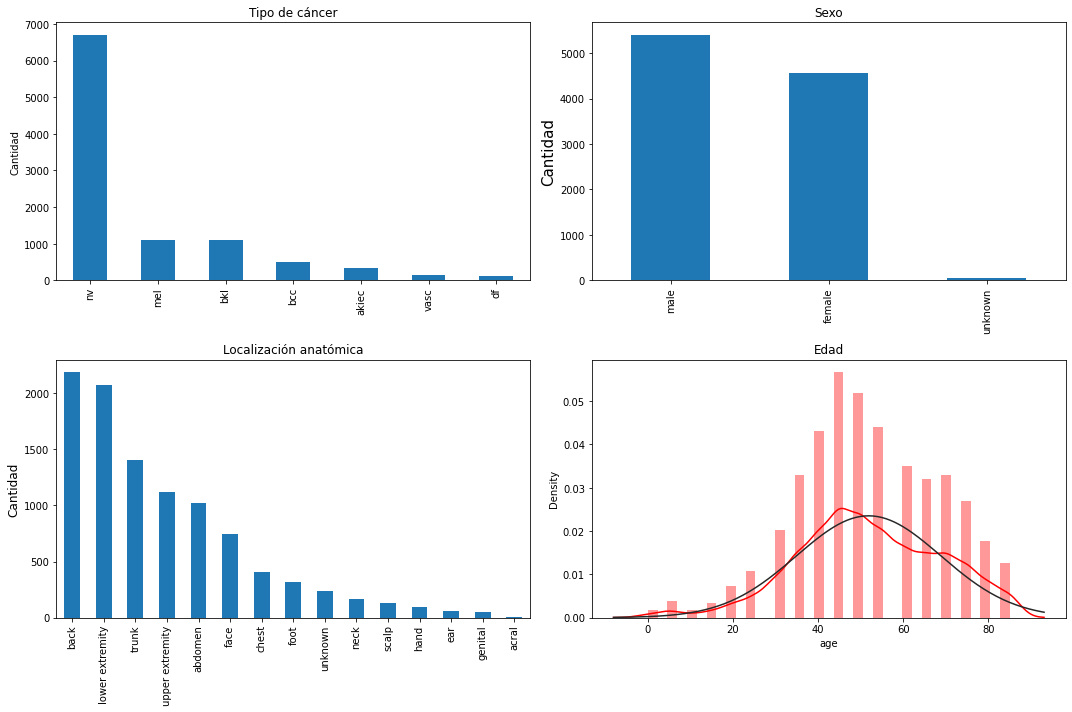

In [4]:
#Ver la distribución de los datos
fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(221)
data_skin['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Cantidad')
ax1.set_title('Tipo de cáncer');

ax2 = fig.add_subplot(222)
data_skin['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Cantidad', size=15)
ax2.set_title('Sexo');

ax3 = fig.add_subplot(223)
data_skin['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Cantidad',size=12)
ax3.set_title('Localización anatómica')

ax4 = fig.add_subplot(224)
sample_age = data_skin[pd.notnull(data_skin['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Edad')

plt.tight_layout()
plt.show()

In [ ]:
#Contar la cantidad de imágenes de cada clase
data_skin['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [ ]:
#Definir el submuestreo a utilizar para balancear la base de datos
limite_clases = data_skin['dx'].value_counts()[2]
limite_clases

1099

In [ ]:
#Extraer las imágenes submuestreadas en dataframes separados
df_type_0 = data_skin[data_skin['dx']=='nv'][0:limite_clases]
df_type_1 = data_skin[data_skin['dx']=='mel'][0:limite_clases]
df_type_2 = data_skin[data_skin['dx']=='bkl'][0:limite_clases]

In [ ]:
#Concatenar los dataframes separados en uno solo ya balanceado
data_skin_bal = pd.concat([df_type_0, df_type_1, df_type_2])

print(data_skin_bal['dx'].value_counts())

nv     1099
mel    1099
bkl    1099
Name: dx, dtype: int64


In [ ]:
#Definición del etiquetador para las clases

l_encode = LabelEncoder()
l_encode.fit(data_skin_bal['dx'])
LabelEncoder()
print(list(l_encode.classes_))

['bkl', 'mel', 'nv']


In [ ]:
#Etiquetamos cada clase existente en el dataframe balanceado
data_skin_bal['label'] = l_encode.transform(data_skin_bal['dx'])
print(data_skin_bal.sample(10))

        lesion_id      image_id   dx    dx_type   age     sex  \
234   HAM_0005131  ISIC_0034235  bkl      histo  80.0    male   
1544  HAM_0002086  ISIC_0033814  mel      histo  70.0    male   
3491  HAM_0000473  ISIC_0027356   nv  follow_up  35.0    male   
1229  HAM_0000492  ISIC_0028445  mel      histo  75.0    male   
807   HAM_0000835  ISIC_0025378  bkl   confocal  55.0  female   
1954  HAM_0004779  ISIC_0024823  mel      histo  35.0    male   
3928  HAM_0005253  ISIC_0026715   nv  follow_up  55.0  female   
991   HAM_0002355  ISIC_0029202  bkl  consensus  35.0    male   
3100  HAM_0002151  ISIC_0029870   nv  follow_up  65.0    male   
3704  HAM_0001959  ISIC_0027600   nv  follow_up  45.0  female   

         localization  label  
234             scalp      0  
1544             face      1  
3491             neck      2  
1229          abdomen      1  
807              face      0  
1954             back      1  
3928  lower extremity      2  
991           abdomen      0  
3100 

In [ ]:
#Contamos la cantidad de imagenes de cada clase para verificar que se aplicó correctamente el balanceo de datos
data_skin_bal['dx'].value_counts()

nv     1099
mel    1099
bkl    1099
Name: dx, dtype: int64

In [ ]:
#Obtenemos todas las rutas de las imágenes a utilizar para el entrenamiento y validación del modelo
#Las imágenes se encuentran en carpetas individuales con el nombre de la clase
import glob
image_path = glob.glob('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/DATA_ORGANIZED/classes/**/*.jpg')

In [ ]:
#Código que solo se ejecuta una sola vez

#Creamos carpetas con el nombre de cada clase en un directorio de destino
os.mkdir('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/DATA_BALANCED/bkl/')
os.mkdir('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/DATA_BALANCED/mel/')
os.mkdir('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/DATA_BALANCED/nv/')

In [ ]:
#Código que copia imágenes del directorio desbalanceado a un directorio balanceado
registro_id = []
for id in data_skin_bal['image_id']:
  registro_id.append(id)
  find_path = [s for s in image_path if id in s]
  for path in find_path:
    p = path.split('/')
    if 'bkl' in p:
      shutil.copy(path,'/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/DATA_BALANCED/bkl/')
    elif 'mel' in p:
      shutil.copy(path,'/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/DATA_BALANCED/mel/')
    elif 'nv' in p:
      shutil.copy(path,'/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/DATA_BALANCED/nv/')



In [5]:
#Verificamos que se hayan copiado bien las imágenes al directorio balanceado
arc_akiec = os.listdir('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/DATA_BALANCED/nv/')
len(arc_akiec)

1099

# **Creación de Data Generator**

In [5]:
#Se crea el generador de imágenes, con normalización, data augmentation y con el 15% de las imágenes para validación
data_generator = ImageDataGenerator(rescale = 1.0/255.0,validation_split = 0.15,
                                    rotation_range = 20, horizontal_flip=True, zoom_range = 0.2)

In [6]:
#Se define el generador de imágenes para el entrenamiento y la validación, con un batch de 32 e imágenes redimensionadas a 64x64 píxeles
path_classes = '/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/DATA_BALANCED/'
train_image_generator = data_generator.flow_from_directory(
    directory = path_classes,
    class_mode = 'categorical',
    batch_size = 32,
    target_size = (64,64),
    subset = 'training'
)
val_image_generator = data_generator.flow_from_directory(
    directory = path_classes,
    class_mode = 'categorical',
    batch_size = 32,
    target_size = (64, 64),
    subset = 'validation'
)

Found 2805 images belonging to 3 classes.
Found 492 images belonging to 3 classes.


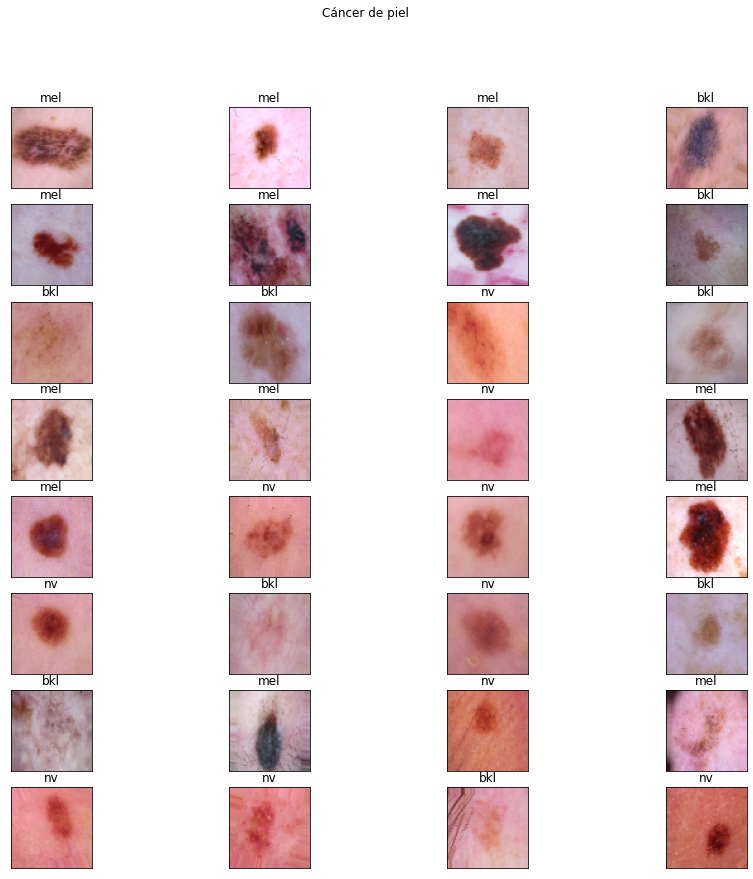

In [7]:
#Visualizamos las imágenes de un batch del generador de imágenes
x, y = next(train_image_generator)
classes = train_image_generator.class_indices
fig = plt.figure(figsize=(15,14))
fig.suptitle('Cáncer de piel')
for i in range(0, 32):
  image = x[i]
  y_search = y[i,:]
  idx = list(np.where(y_search==1))
  n_type = list(classes.keys())[list(classes.values()).index(idx[0])]
  fig.add_subplot(8,4,i+1)
  plt.imshow(image,cmap='gray')
  plt.title(n_type)
  plt.xticks([])
  plt.yticks([])
  n_type = ''

# **Carga de modelo pre-entrenado y sus métricas en .csv**

In [ ]:
#Linea de código opcional para cargar un modelo pre-entrenado en caso de que no logren entrenar durante 100 épocas seguidas
import csv

total_loss = []
total_val_loss = []
total_acc = []
total_val_acc = []

model = load_model('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/DATA_BALANCED/90_epochs_cancer.h5')

with open('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/DATA_BALANCED/acc_90.csv','r') as archivo:
  lector = csv.reader(archivo,delimiter=',')
  next(lector, None)
  for fila in lector:
    total_acc.append(float(fila[1]))
    total_acc = list(total_acc)

with open('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/DATA_BALANCED/val_acc_90.csv','r') as archivo:
  lector = csv.reader(archivo,delimiter=',')
  next(lector, None)
  for fila in lector:
    total_val_acc.append(float(fila[1]))
    total_val_acc = list(total_val_acc)

with open('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/DATA_BALANCED/loss_90.csv','r') as archivo:
  lector = csv.reader(archivo,delimiter=',')
  next(lector, None)
  for fila in lector:
    total_loss.append(float(fila[1]))
    total_loss = list(total_loss)

with open('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/DATA_BALANCED/val_loss_90.csv','r') as archivo:
  lector = csv.reader(archivo,delimiter=',')
  next(lector, None)
  for fila in lector:
    total_val_loss.append(float(fila[1]))
    total_val_loss = list(total_val_loss)

# **Definición de red neuronal convolucional**

In [8]:
#Se definen las clases y la estructura de la red neuronal convolucional
n_classes = 3

model = Sequential()
model.add(Conv2D(256, (3,3), activation='relu', input_shape=(64,64,3)))
model.add(MaxPool2D(pool_size=(2,2,)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2,)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2,)))
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(3, activation = 'softmax'))
model.summary()

#Compilamos el modelo, con una función de perdida categorical_crossentropy y un optimizador Adam
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 128)       0

# **Entrenamiento de la red neuronal convolucional**

In [9]:
#Definimos vacios los contenedores de los resultados durante cada epoca (loss y acc)
total_loss = []
total_val_loss = []
total_acc = []
total_val_acc = []

In [10]:
num_epochs = 10
for i in range(0,10):
  print("Batch de entrenamiento: "+str(i+1))
  #Entrenamiento del modelo
  historial = model.fit(
    train_image_generator,
    steps_per_epoch = train_image_generator.samples//train_image_generator.batch_size,
    validation_data = val_image_generator,
    validation_steps = val_image_generator.samples // val_image_generator.batch_size,
    epochs = num_epochs)
  #Guardamos cada 10 épocas de entrenamiento por seguridad en un archivo .h5
  model.save('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/GPU/'+str((i+1)*10)+'_epochs_cancer.h5')
  #Obtenemos la función de perdida y su validación de cada 10 épocas
  loss = historial.history['loss']
  val_loss = historial.history['val_loss']
  #Obtenemos su precisión y la validación de cada 10 épocas
  acc = historial.history['acc']
  val_acc = historial.history['val_acc']
  #Guardamos los valores de función de perdida y precisión en vectores
  total_loss.extend(loss)
  total_val_loss.extend(val_loss)
  total_acc.extend(acc)
  total_val_acc.extend(val_acc)
  #Transformamos los vectores a dataframe
  df_loss = pd.DataFrame(total_loss)
  df_val_loss = pd.DataFrame(total_val_loss)
  df_acc = pd.DataFrame(total_acc)
  df_val_acc = pd.DataFrame(total_val_acc)
  #Guardamos los dataframes como archivos .csv para salvar la información
  df_loss.to_csv('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/GPU/loss_'+str((i+1)*10)+'.csv')
  df_val_loss.to_csv('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/GPU/val_loss_'+str((i+1)*10)+'.csv')
  df_acc.to_csv('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/GPU/acc_'+str((i+1)*10)+'.csv')
  df_val_acc.to_csv('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/GPU/val_acc_'+str((i+1)*10)+'.csv')



Batch de entrenamiento: 1
Epoch 1/10
87/87 [==============================] - 1271s 15s/step - loss: 0.8357 - acc: 0.5893 - val_loss: 0.6673 - val_acc: 0.6750
Epoch 2/10
87/87 [==============================] - 37s 427ms/step - loss: 0.6804 - acc: 0.6754 - val_loss: 0.6191 - val_acc: 0.7208
Epoch 3/10
87/87 [==============================] - 37s 429ms/step - loss: 0.6239 - acc: 0.6964 - val_loss: 0.5407 - val_acc: 0.7729
Epoch 4/10
87/87 [==============================] - 38s 441ms/step - loss: 0.5561 - acc: 0.7526 - val_loss: 0.5538 - val_acc: 0.7854
Epoch 5/10
87/87 [==============================] - 37s 427ms/step - loss: 0.5212 - acc: 0.7746 - val_loss: 0.5408 - val_acc: 0.7563
Epoch 6/10
87/87 [==============================] - 37s 426ms/step - loss: 0.5235 - acc: 0.7746 - val_loss: 0.4994 - val_acc: 0.7812
Epoch 7/10
87/87 [==============================] - 40s 454ms/step - loss: 0.5259 - acc: 0.7753 - val_loss: 0.5487 - val_acc: 0.7417
Epoch 8/10
87/87 [=========================

In [13]:
#Evaluamos la precisión final del modelo entrenado

score = model.evaluate(val_image_generator)
print('Test accuracy:', score[1])

16/16 [==============================] - 8s 462ms/step - loss: 0.4412 - acc: 0.8171
Test accuracy: 0.8170731663703918


# **Visualización gráfica de los entrenamientos (no ejecutar aún)**

In [ ]:
#En caso de ya contar con los archivos .csv de los entrenamientos, aquí se cargan

#Definimos vacios los contenedores de los resultados durante cada epoca (loss y acc)
total_loss = []
total_val_loss = []
total_acc = []
total_val_acc = []

#Cargamos los archivos .csv de loss y accuracy, junto con su validación
with open('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/DATA_BALANCED/acc_100.csv','r') as archivo:
  lector = csv.reader(archivo,delimiter=',')
  next(lector, None)
  for fila in lector:
    total_acc.append(float(fila[1]))
    total_acc = list(total_acc)

with open('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/DATA_BALANCED/val_acc_100.csv','r') as archivo:
  lector = csv.reader(archivo,delimiter=',')
  next(lector, None)
  for fila in lector:
    total_val_acc.append(float(fila[1]))
    total_val_acc = list(total_val_acc)

with open('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/DATA_BALANCED/loss_100.csv','r') as archivo:
  lector = csv.reader(archivo,delimiter=',')
  next(lector, None)
  for fila in lector:
    total_loss.append(float(fila[1]))
    total_loss = list(total_loss)

with open('/content/drive/MyDrive/DEEP LEARNING/SKIN CANCER/DATA_BALANCED/val_loss_100.csv','r') as archivo:
  lector = csv.reader(archivo,delimiter=',')
  next(lector, None)
  for fila in lector:
    total_val_loss.append(float(fila[1]))


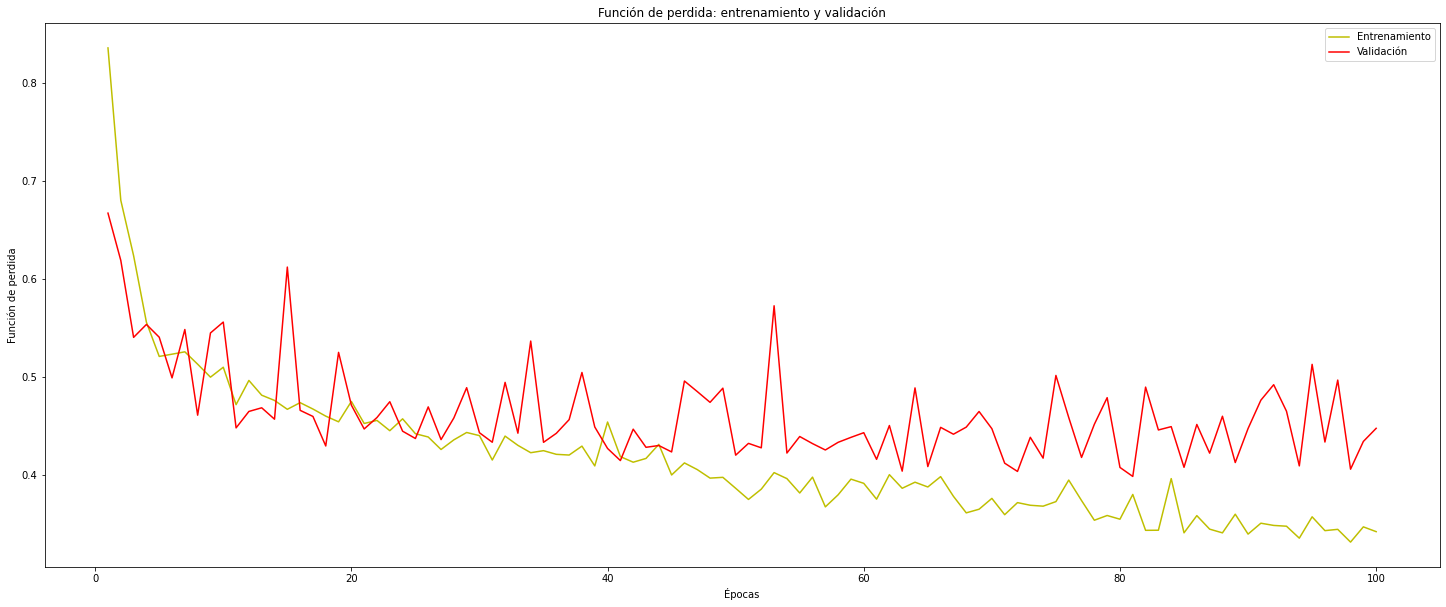

In [14]:
#Visualizamos la función de perdida y su validación
epochs = range(1, len(total_loss) + 1)
plt.figure(figsize=[25,10])
plt.plot(epochs, total_loss, 'y', label='Entrenamiento')
plt.plot(epochs, total_val_loss, 'r', label='Validación')
plt.title('Función de perdida: entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Función de perdida')
plt.legend()
plt.show()

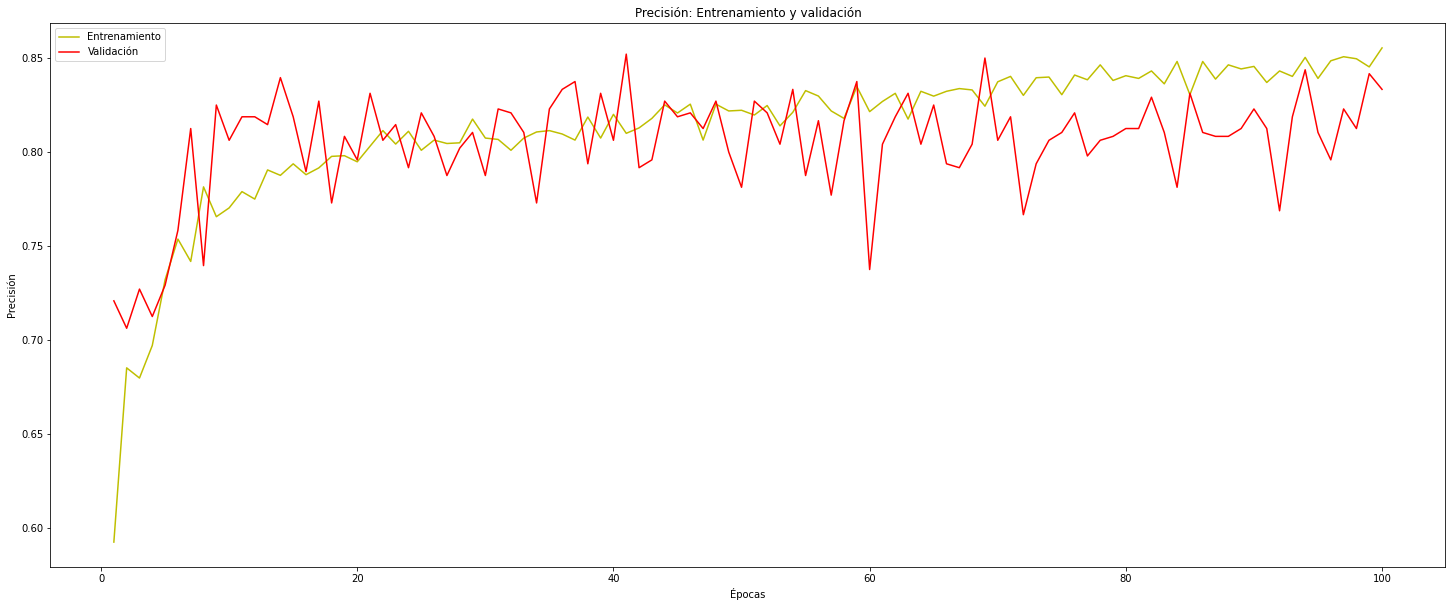

In [ ]:
#Visualizamos el accuracy y su validación
epochs = range(1, len(total_acc) + 1)
plt.figure(figsize=[25,10])
plt.plot(epochs, total_acc, 'y', label='Entrenamiento')
plt.plot(epochs, total_val_acc, 'r', label='Validación')
plt.title('Precisión: Entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()
